# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
'''
1. Package Imports: All the necessary packages and modules are imported in the first cell of the notebook
'''
import torch
from torch import nn, optim 
import torch.nn.functional as F 

import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

import time
import json
from collections import OrderedDict
from PIL import Image

print("Import Done")

Import Done


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
Tesla K80


In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
'''
2. Training data augmentation: torchvision transforms are used to augment the training data 
   with random scaling, rotations, mirroring, and/or cropping
3. Data normalization: The training, validation, and testing data is appropriately cropped and normalized
4. Data batching: The data for each set is loaded with torchvision's DataLoader
5. Data loading: The data for each set (train, validation, test) is loaded with torchvision's ImageFolder
'''

# training set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ])

# validation set
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

# testing set
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
print("Training", train_data)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms) # cost
print("\nValidation", valid_data) 
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
print("\nTesting", test_data)
image_datasets = [train_data, valid_data, test_data]

# TODO: Using the image datasets and the trainforms, define the dataloaders
# Uses shuffle=True so the order of the images does not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
dataloaders = [trainloader, validloader, testloader]

Training Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

Validation Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flowers/valid
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    print(json.dumps(cat_to_name, indent=4)) # display a JSON file with pretty formatting

{
    "21": "fire lily",
    "3": "canterbury bells",
    "45": "bolero deep blue",
    "1": "pink primrose",
    "34": "mexican aster",
    "27": "prince of wales feathers",
    "7": "moon orchid",
    "16": "globe-flower",
    "25": "grape hyacinth",
    "26": "corn poppy",
    "79": "toad lily",
    "39": "siam tulip",
    "24": "red ginger",
    "67": "spring crocus",
    "35": "alpine sea holly",
    "32": "garden phlox",
    "10": "globe thistle",
    "6": "tiger lily",
    "93": "ball moss",
    "33": "love in the mist",
    "9": "monkshood",
    "102": "blackberry lily",
    "14": "spear thistle",
    "19": "balloon flower",
    "100": "blanket flower",
    "13": "king protea",
    "49": "oxeye daisy",
    "15": "yellow iris",
    "61": "cautleya spicata",
    "31": "carnation",
    "64": "silverbush",
    "68": "bearded iris",
    "63": "black-eyed susan",
    "69": "windflower",
    "62": "japanese anemone",
    "20": "giant white arum lily",
    "38": "great masterwort",
   

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [6]:
# TODO: Build and train your network
'''
6. Pretrained Network: A pretrained network such as VGG16 is loaded from torchvision.models and the parameters are frozen
'''
# uses vgg16, VGG networks work great and are straightforward to use
# Model has been pre-trained on the ImageNet dataset
model = models.vgg16(pretrained=True)

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
'''
7.Feedforward Classifier: A new feedforward network is defined for use as a classifier using the features as input
'''
# The weights of the pretrained model are frozen to avoid backpropping through them
for param in model.parameters():
    param.requires_grad = False
    
# Defines the classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 256)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(256, len(cat_to_name))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replaces the pretrained classifier with the one created above
model.classifier = classifier
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4096, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [10]:
'''
8. Training the network: The parameters of the feedforward classifier are appropriately trained, 
   while the parameters of the feature network are left static
10. Validation Loss and Accuracy: During training, the validation loss and accuracy are displayed
'''
# Trains the model
# Has to be trained with GPU, training locally is abysmally slow with VGG16

# Sets device to either cuda or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'The device in use is {device}.\n')

# Sets the training hyperparameters
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001) # Makes use of momentum to avoid local minima
criterion = nn.NLLLoss() # Recommended when using Softmax

epochs = 3 # Should be OK to avoid overfitting
print_every = 20 # Model trains on 20 batches of images at a time

running_loss = running_accuracy = 0
validation_losses, training_losses = [],[]

start = time.time() # Defines start time
print('Training Start...')

# Defines the training process
for e in range(epochs):
    batches = 0 
    # Turns on training mode
    model.train()

    for images, labels in trainloader:
        batches += 1

        # Moves images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Pushes batch through network
        outputs = model.forward(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # Calculates the metrics
        ps = torch.exp(outputs)
        top_ps, top_class = ps.topk(1,dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        accuracy = matches.mean()

        # Resets optimiser gradient and tracks metrics
        optimizer.zero_grad()
        running_loss += loss.item()
        running_accuracy += accuracy.item()

        # Runs the model on the validation set every 5 loops
        if batches % print_every == 0:
            # Sets the metrics
            validation_loss = 0
            validation_accuracy = 0
            model.eval() # Turns on evaluation mode
            with torch.no_grad(): # Turns off calculation of gradients
                for images, labels in validloader:
                    images, labels = images.to(device),labels.to(device)
                    outputs = model.forward(images)
                    loss = criterion(outputs, labels)
                    ps = torch.exp(outputs)
                    top_ps, top_class = ps.topk(1,dim=1)
                    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
                    accuracy = matches.mean()

                    # Tracks validation metrics (test of the model's progress)
                    validation_loss += loss.item()
                    validation_accuracy += accuracy.item()
                
            # Tracks training metrics
            validation_losses.append(running_loss/print_every)
            training_losses.append(validation_loss/len(validloader))
                
            # Prints out metrics
            print(f'Epoch {e+1}/{epochs} , Batch {batches}',
                  f', Training Loss: {running_loss/print_every:.3f}',
                  f', Training Accuracy: {running_accuracy/print_every*100:.2f}%',
                  f', Validation Loss: {validation_loss/len(validloader):.3f}',
                  f', Validation Accuracy: {validation_accuracy/len(validloader)*100:.2f}%')

            # Resets the metrics and turns on training mode
            running_loss = running_accuracy = 0
            model.train()
            
time_elapsed = time.time() - start
print(f'Time spent training: {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')

The device in use is cuda.

Training Start...
Epoch 1/3 , Batch 20 , Training Loss: 5.871 , Training Accuracy: 9.06% , Validation Loss: 3.300 , Validation Accuracy: 26.76%
Epoch 1/3 , Batch 40 , Training Loss: 2.927 , Training Accuracy: 31.72% , Validation Loss: 1.838 , Validation Accuracy: 53.74%
Epoch 1/3 , Batch 60 , Training Loss: 2.025 , Training Accuracy: 48.44% , Validation Loss: 1.299 , Validation Accuracy: 63.25%
Epoch 1/3 , Batch 80 , Training Loss: 1.653 , Training Accuracy: 56.56% , Validation Loss: 1.067 , Validation Accuracy: 70.66%
Epoch 1/3 , Batch 100 , Training Loss: 1.404 , Training Accuracy: 61.88% , Validation Loss: 0.888 , Validation Accuracy: 75.52%
Epoch 2/3 , Batch 20 , Training Loss: 1.370 , Training Accuracy: 77.66% , Validation Loss: 0.717 , Validation Accuracy: 80.00%
Epoch 2/3 , Batch 40 , Training Loss: 1.108 , Training Accuracy: 69.38% , Validation Loss: 0.877 , Validation Accuracy: 75.96%
Epoch 2/3 , Batch 60 , Training Loss: 1.036 , Training Accuracy: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
'''
9. Testing Accuracy: The network's accuracy is measured on the test data
'''
# TODO: Do validation on the test set
# Defines test accuracy
test_accuracy = 0

# Defines tests
for images, labels in testloader:
    model.eval() # Turns on evaluation mode
    images, labels = images.to(device), labels.to(device) # Sends images and labels to the GPU
    log_ps = model.forward(images) # Pushes images through the model
    ps = torch.exp(log_ps) # Applies softmax to the output
    top_ps, top_class = ps.topk(1,dim=1) # Gets the top probabilities and classes
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor) # Matches predicted and actual classes
    accuracy = matches.mean() # Calculates the accuracy
    test_accuracy += accuracy # Tracks test accuracy

# Prints metrics
print(f'Test Accuracy: {test_accuracy/len(testloader)*100:.2f}%')

Test Accuracy: 83.38%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
'''
12. Saving the model: The trained model is saved as a checkpoint along with associated hyperparameters 
    and the class_to_idx dictionary
'''
# TODO: Save the checkpoint 
# Improves label to name mapping
model.class_to_idx = train_data.class_to_idx 
# Defines model's checkpoint
checkpoint = {'state_dict': model.state_dict(),
              'class_to_idx': train_data.class_to_idx,
              'optimizer': optimizer.state_dict(),
             }
# Saves model in current directory
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
'''
11. Loading checkpoints: There is a function that successfully loads a checkpoint and rebuilds the model
'''
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Defines checkpoint as file created above
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model

In [14]:
model = load_checkpoint('checkpoint.pth')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
'''
13. Image Processing: The process_image function successfully converts a PIL image into 
    an object that can be used as input to a trained model
'''
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # define the image transformations to be applied
    image_transforms = transforms.Compose([transforms.Resize(256), # resize the image to 256 pixels on the shortest side
                                           transforms.CenterCrop(224), # crop the center 224x224 pixels from the image
                                           transforms.ToTensor(), # convert the image to a PyTorch tensor
                                           # normalize the image channels with mean and std values
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
    # Processes a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    
    # Applies the specified transformations
    tensor_image = image_transforms(pil_image)
    return tensor_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [229]:
image_path = 'flowers/test/47/image_04993.jpg'
process_image(image_path)

tensor([[[-1.2274, -1.2788, -1.2959,  ..., -1.5014, -1.5185, -1.4843],
         [-1.3644, -1.3815, -1.3302,  ..., -1.5699, -1.5357, -1.5357],
         [-1.4329, -1.4329, -1.3815,  ..., -1.6555, -1.5699, -1.6042],
         ...,
         [-1.6213, -1.5185, -1.3815,  ..., -1.9124, -1.5185, -1.3130],
         [-1.5699, -1.5699, -1.6042,  ..., -2.0152, -1.4672, -1.2445],
         [-1.6727, -1.6898, -1.7069,  ..., -1.9295, -1.3987, -1.2788]],

        [[-0.3200, -0.3725, -0.3375,  ..., -1.1253, -1.2479, -1.3529],
         [-0.4251, -0.4426, -0.4076,  ..., -1.3529, -1.4055, -1.4055],
         [-0.4776, -0.4951, -0.4776,  ..., -1.4755, -1.4755, -1.4755],
         ...,
         [-1.4055, -1.2654, -1.1253,  ..., -1.4055, -0.8277, -0.3550],
         [-1.4580, -1.4580, -1.4930,  ..., -1.4230, -0.6001, -0.2675],
         [-1.5630, -1.5805, -1.5980,  ..., -1.3354, -0.5301, -0.2850]],

        [[-0.2881, -0.3404, -0.2881,  ..., -1.2119, -1.2641, -1.2467],
         [-0.4275, -0.4275, -0.2707,  ..., -1

In [230]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

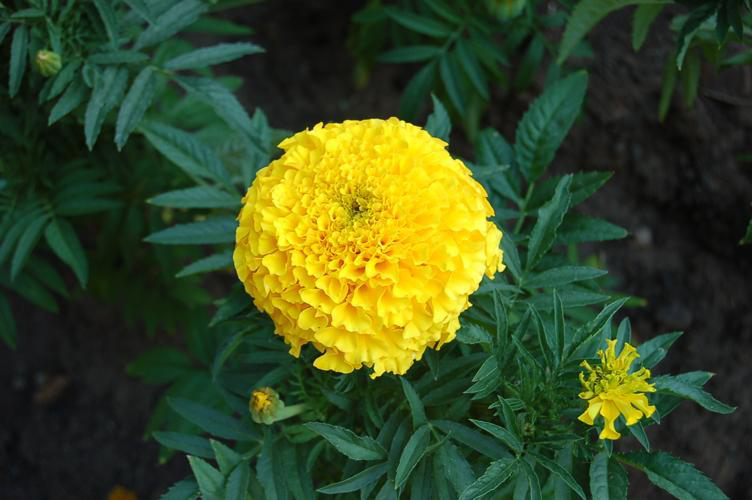

In [231]:
# Displays original image
original_image = Image.open(image_path)
original_image

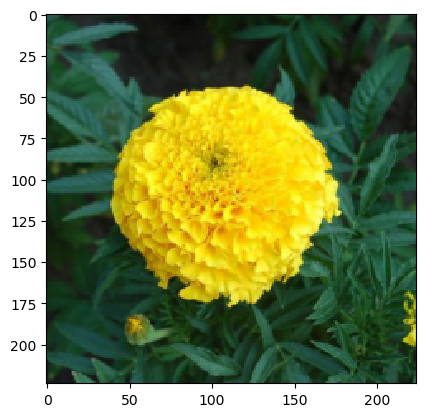

In [232]:
# displays preprocessed image
imshow(process_image(image_path).numpy())

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [233]:
'''
14. Class Prediction: The predict function successfully takes the path to an image and a checkpoint, 
    then returns the top K most probably classes for that image
'''
def predict(image_path, model, topk=5):
    # TODO: Implement the code to predict the class from an image file
    # Set the model to evaluation mode
    model.eval()

    # Move the model to CPU
    model.cpu()

    # Process the image
    image = process_image(image_path)

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Disable gradient calculation
    with torch.no_grad():
        # Forward pass through the model
        output = model(image)

        # Get the top k probabilities and labels
        probs, labels = torch.topk(output, topk)

        # Convert the probabilities to a tensor of actual probabilities
        probs = probs.exp()

        # Reverse the class to index mapping
        class_to_idx_rev = {model.class_to_idx[k]: k for k in model.class_to_idx}

        # Convert the labels from tensor to numpy array and get the corresponding classes
        classes = []
        for label in labels.numpy()[0]:
            classes.append(class_to_idx_rev[label])

        # Return the probabilities and classes as numpy arrays
        return probs.numpy()[0], classes

In [234]:
# Call the predict function and store the probabilities and classes
probs, classes = predict(image_path, model)

# Print the probabilities and classes
print(probs)
print(classes)

[  9.99960661e-01   2.91014057e-05   3.47859532e-06   3.08455219e-06
   2.57156603e-06]
['47', '96', '48', '27', '16']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Text(0.5,0,'Probabilities')

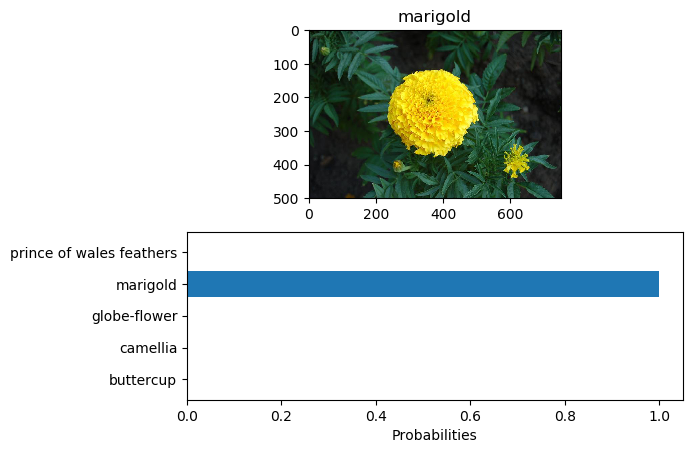

In [235]:
'''
15. Sanity Checking with matplotlib: A matplotlib figure is created displaying an image and 
    its associated top 5 most probable classes with actual flower names
'''
# TODO: Display an image along with the top 5 classes
flower_class = []
for flower in classes:
    flower_name = cat_to_name[str(flower)]
    flower_class.append(flower_name)
flower_name = flower_class[0]

plt.subplot(2, 1, 1)
plt.title(flower_name)
plt.imshow(original_image)

plt.subplot(2, 1, 2)
plt.barh(flower_class, probs)
plt.xlabel('Probabilities')

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace